# Proyección de las trayectorias con cMDS

In [7]:
import pandas as pd
import numpy as np
import pytraj as pyt
import glob, os, sys
import pickle
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
sys.path.append(r'..')

## Carga de los datos de referencia

In [2]:
prot_name = 'cdk2'

In [3]:
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
path_to_json_file = glob.glob((os.path.join('..', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys_LIGS_INFO_LABELS.json')))[0]
                      
df_prot = pd.read_json(path_to_json_file)

In [4]:
from modules.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",")
pocket_residues = get_pocket_residues(sep=",")

In [5]:
mask_pisani = F"(:{pisiani_residues})&(@CA)"

In [9]:
# Carga de la trayectoria de estructuras cristalograficas
path_mds_obj = os.path.join('..', 'data', 'trajectory_analysis', 'cMDS_Pisani_402_obj.pyobj')
#
with open(path_mds_obj, 'rb') as f:
    mds_pisani_402 = pickle.load(f)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'talk', style = 'white')
from modules.plotting_functions import plot_points, plot_anotation_labels

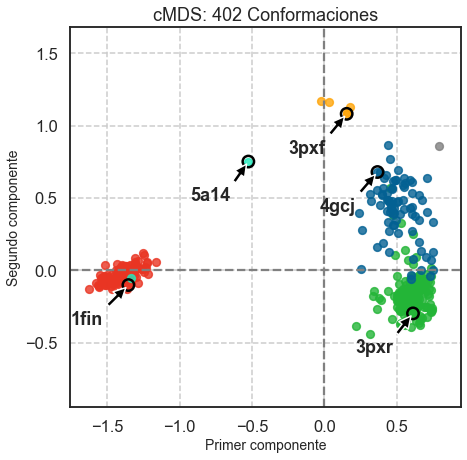

In [12]:
mds_plot = mds_pisani_402
ref_structs_dict = {"1fin": "red", "5a14": "cyan", "3pxr": "green", "4gcj": "blue", "3pxf": "orange"}
# Se genera la gráfica
fig = plt.figure(figsize=(7, 7))
plot_points(mds = mds_plot[0], labels = df_prot.Labels_conf, alpha=0.8,
                             title = "cMDS: 402 Conformaciones")
plot_anotation_labels(df_prot.index,  ref_structs_dict.keys(), mds_plot[0][0], mds_plot[0][1], 
                      xytext_delta=[0.4, 0.3], s=130)

## Proyección de trayectorias
### Cargamos el json con las proyecciones

In [14]:
path_mds_obj = os.path.join('..', 'data', 'trajectory_analysis', 'mds_all_traj_projections.obj')
#
with open(path_mds_obj, 'rb') as f:
    dic_trajs = pickle.load(f)

## Visualización con bokeh

In [24]:
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
from bokeh.models import ResetTool, PanTool, WheelZoomTool, ColumnDataSource

In [39]:
f = figure()

# Styling del plot
f.title.text = 'Trajectories projection'
f.title.text_font_size = '2em'
f.title.align = 'center'

# 
f.axis.axis_line_width = 3

# Plot de la referencia de pisani
ref_pisani = ColumnDataSource({
    'x': mds_plot[0][0], 'y': mds_plot[0][1]})

# 
f.scatter('x', 'y', source = ref_pisani)

GlyphRenderer(id='1826', ...)

In [40]:
output_notebook()
show(f)

Loading BokehJS ...